In [1]:
import math
import os
import random

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.utils import spectral_norm
from torch.utils.data import DataLoader
from torchvision import transforms, utils as vutils
from torchvision.datasets import ImageFolder
from tqdm.auto import tqdm

In [2]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, base_channels=64):
        super().__init__()
        self.model = nn.Sequential(
            #[B, 3, 128, 128]
            spectral_norm(nn.Conv2d(img_channels, base_channels, 4, stride=2, padding=1)), # [B, 64, 64, 64]
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(base_channels, base_channels * 2, 4, stride=2, padding=1)), # [B, 128, 32, 32]
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(base_channels * 2, base_channels * 4, 4, stride=2, padding=1)), # [B, 256, 16, 16]
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(base_channels * 4, base_channels * 8, 4, stride=2, padding=1)), # [B, 512, 8, 8]
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(base_channels * 8, 1, 4, stride=1, padding=0)), # [B, 1, 5, 5]
        )

    def forward(self, x):
        return self.model(x).view(-1) # [B]

In [3]:
class SelfAttention(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.query = nn.utils.spectral_norm(nn.Conv2d(in_ch, in_ch // 8, 1))
        self.key = nn.utils.spectral_norm(nn.Conv2d(in_ch, in_ch // 8, 1))
        self.value = nn.utils.spectral_norm(nn.Conv2d(in_ch, in_ch, 1))
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.shape
        q = self.query(x).view(B, -1, H*W).permute(0, 2, 1) # [B, HW, C/8]
        k = self.key(x).view(B, -1, H*W) # [B, C/8, HW]
        attn = torch.softmax(q @ k, dim=-1) # [B, HW, HW]
        v = self.value(x).view(B, C, H*W) # [B, C, HW]
        out = (v @ attn.permute(0, 2, 1)).view(B, C, H, W) # [B, C, H, W]
        return self.gamma * out + x

In [4]:
class GenBlock(nn.Module):
    def __init__(self, in_ch, out_ch, use_norm=True):
        super().__init__()
        layers = [
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
        ]
        if use_norm:
            layers.append(nn.InstanceNorm2d(out_ch))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        layers.append(nn.Conv2d(out_ch, out_ch, 3, padding=1))
        if use_norm:
            layers.append(nn.InstanceNorm2d(out_ch))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim=128, img_channels=3, base_channels=64, resolution=128):
        super().__init__()
        assert resolution in (64, 128, 256)
        num_ups = int(math.log2(resolution) - 2)

        c0 = base_channels * 16
        # [B, z_dim]
        self.fc = nn.Linear(z_dim, 16 * c0)  # [B, 16c0]

        chs = [c0]
        for _ in range(num_ups):
            chs.append(max(chs[-1] // 2, base_channels))

        blocks = []
        for i in range(num_ups):
            blk = GenBlock(chs[i], chs[i + 1],
                           use_norm=(i < num_ups - 2))
            blocks.append(blk)
        self.blocks = nn.ModuleList(blocks)

        self.to_rgb = nn.Sequential(
            nn.Conv2d(chs[-1], img_channels, 3, padding=1),  # [B, 3, resolution, resolution]
            nn.Tanh()
        )

        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        if isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, z):
        # z: [B, z_dim]
        x = self.fc(z).view(z.size(0), -1, 4, 4)  # [B, c0, 4, 4]
        for blk in self.blocks:
            x = blk(x)
        x = self.to_rgb(x)  # [B, 3, H, W]
        return x

In [6]:
def d_hinge_loss(real_logits, fake_logits):
    return torch.relu(1. - real_logits).mean() + torch.relu(1. + fake_logits).mean()

def g_hinge_loss(fake_logits):
    return (-fake_logits).mean()

def r1_regularization(real_imgs, real_logits):
    grad_real = torch.autograd.grad(
        outputs=real_logits.sum(), inputs=real_imgs,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    r1 = grad_real.pow(2).reshape(grad_real.size(0), -1).sum(1).mean()
    return r1

In [7]:
DATASET_NAME = "StanfordCars"
RESOLUTION = 128
Z_DIM = 256
G_CH = 128
D_CH = 256
BATCH_SIZE = 64
EPOCHS = 70
LR_G = 1e-4
LR_D = 4e-4
BETAS = (0.0, 0.99)
R1_GAMMA = 5
R1_EVERY = 32
ACCUM_STEPS = 4
WORKERS = 4
SEED = 42
DATASET_DIR = f"Datasets/{DATASET_NAME}"
SAMPLES_DIR = f"Samples/{DATASET_NAME}"
WEIGHTS_DIR = f"Weights/{DATASET_NAME}"
os.makedirs(SAMPLES_DIR, exist_ok=True)
os.makedirs(WEIGHTS_DIR, exist_ok=True)

torch.manual_seed(SEED)
random.seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [8]:
def make_loader(resolution=128):
    T = transforms.Compose([
        transforms.Resize(resolution),
        transforms.CenterCrop(resolution),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3),
    ])
    train = ImageFolder(root=DATASET_DIR, transform=T)
    return DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS, drop_last=False, persistent_workers=True, pin_memory=False)

In [9]:
@torch.inference_mode()
def show_and_save_samples(G, z_fixed, outdir, epoch, nrow=None):
    G.eval()
    imgs = G(z_fixed)
    path = os.path.join(outdir, f"epoch_{epoch:03d}.png")
    vutils.save_image(imgs, path, nrow=nrow or int(math.sqrt(imgs.size(0))),
                      normalize=True, value_range=(-1, 1))
    grid = vutils.make_grid(imgs, nrow=nrow or int(math.sqrt(imgs.size(0))),
                            normalize=True, value_range=(-1,1))
    plt.figure(figsize=(6,6))
    plt.axis('off'); plt.imshow(grid.permute(1,2,0).cpu())
    plt.show()
    G.train()

In [10]:
G = Generator(z_dim=Z_DIM, img_channels=3, base_channels=G_CH, resolution=RESOLUTION).to(device)
D = Discriminator(img_channels=3, base_channels=D_CH).to(device)

optG = torch.optim.AdamW(G.parameters(), lr=LR_G, betas=BETAS)
optD = torch.optim.AdamW(D.parameters(), lr=LR_D, betas=BETAS)

scalerG = torch.amp.GradScaler(device)
scalerD = torch.amp.GradScaler(device)

loader = make_loader(RESOLUTION)
z_fixed = torch.randn(36, Z_DIM, device=device)

print(sum(p.numel() for p in G.parameters())/1e6, "M params in G")
print(sum(p.numel() for p in D.parameters())/1e6, "M params in D")

46.325123 M params in G
44.089089 M params in D


Resumed from F:\Programming\Python\TorchBlocks\Weights\StanfordCars\epoch_069.pt, epoch 69


Epoch 69/70:   0%|          | 0/253 [00:17<?, ?it/s]

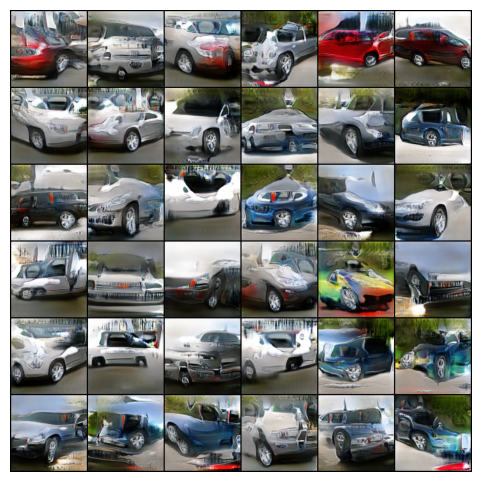

[Epoch 69] d_loss=1.858 g_loss=1.033


Epoch 70/70:   0%|          | 0/253 [00:00<?, ?it/s]

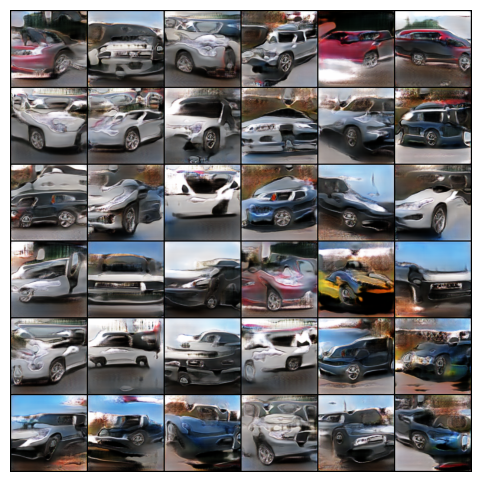

[Epoch 70] d_loss=1.794 g_loss=-0.027


In [11]:
resume_path = os.path.abspath(f"{WEIGHTS_DIR}/epoch_069.pt")
start_epoch = 1
step = 0

if os.path.isfile(resume_path):
    ckpt = torch.load(resume_path, map_location=device)
    G.load_state_dict(ckpt["G"])
    D.load_state_dict(ckpt["D"])
    optG.load_state_dict(ckpt["optG"])
    optD.load_state_dict(ckpt["optD"])
    scalerG.load_state_dict(ckpt["scalerG"])
    scalerD.load_state_dict(ckpt["scalerD"])
    start_epoch = ckpt["epoch"]
    print(f"Resumed from {resume_path}, epoch {start_epoch}")

for epoch in range(start_epoch, EPOCHS + 1):
    pbar = tqdm(loader, desc=f"Epoch {epoch}/{EPOCHS}")
    for real, _ in pbar:
        real = real.to(device, non_blocking=True)

        optD.zero_grad(set_to_none=True)
        z = torch.randn(real.size(0), Z_DIM, device=device)

        with torch.amp.autocast(device):
            fake = G(z).detach()
            real_logits = D(real)
            fake_logits = D(fake)
            d_loss = d_hinge_loss(real_logits, fake_logits)

        scalerD.scale(d_loss / ACCUM_STEPS).backward()

        if R1_EVERY > 0 and (step % R1_EVERY == 0):
            real.requires_grad_(True)
            real_logits_r1 = D(real)
            r1 = r1_regularization(real, real_logits_r1)
            r1_loss = (R1_GAMMA * 0.5) * r1
            scalerD.scale(r1_loss / ACCUM_STEPS).backward()
            real.requires_grad_(False)
        else:
            r1_loss = torch.tensor(0.0, device=device)

        if (step + 1) % ACCUM_STEPS == 0:
            scalerD.step(optD)
            scalerD.update()

        optG.zero_grad(set_to_none=True)
        z = torch.randn(real.size(0), Z_DIM, device=device)
        with torch.amp.autocast(device):
            fake = G(z)
            fake_logits = D(fake)
            g_loss = g_hinge_loss(fake_logits)

        scalerG.scale(g_loss / ACCUM_STEPS).backward()
        if (step + 1) % ACCUM_STEPS == 0:
            scalerG.step(optG); scalerG.update()

        step += 1

        pbar.set_postfix(d_loss=f"{d_loss.item():.3f}", g_loss=f"{g_loss.item():.3f}", r1=f"{r1_loss.item():.3f}")

    show_and_save_samples(G, z_fixed, outdir=SAMPLES_DIR, epoch=epoch)
    torch.save(
        {"G": G.state_dict(), "D": D.state_dict(),
         "optG": optG.state_dict(), "optD": optD.state_dict(),
         "scalerG": scalerG.state_dict(), "scalerD": scalerG.state_dict(),
         "epoch": epoch},
        os.path.join(WEIGHTS_DIR, f"epoch_{epoch:03d}.pt")
    )
    print(f"[Epoch {epoch}] d_loss={d_loss.item():.3f} g_loss={g_loss.item():.3f}")